In [1]:
%matplotlib inline
import seaborn as sns

import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import edward2 as ed
import warnings
import numpy as np
import matplotlib.pyplot as plt

In [18]:
# Data
n_points = 4
n = np.ones(4, dtype=np.float32)*5
deaths = np.array([0, 1, 3, 5], dtype=np.float32)
dose = np.array([-.86,-.3,-.05,.73], dtype=np.float32)


In [19]:
def invlogit(x):
    return tf.exp(x)/(1+tf.exp(x))

def bioassay_model(n,dose):
    alpha = ed.Normal(loc=0., scale=100.,name="alpha")
    beta = ed.Normal(loc=0, scale=100., name="beta")
    theta = invlogit(alpha + beta*dose)
    deaths = ed.Binomial(total_count=n,probs=theta,name="deaths")
    return deaths

log_joint = ed.make_log_joint_fn(bioassay_model)

def target_log_prob_fn(alpha, beta):
  """Unnormalized target density as a function of states."""
  return log_joint(
      n=n,
      dose=dose,
      alpha=alpha,
      beta=beta,
      deaths=deaths)

In [20]:
num_results = 5000
num_burnin_steps = 3000

states, kernel_results = tfp.mcmc.sample_chain(
    num_results=num_results,
    num_burnin_steps=num_burnin_steps,
    current_state=[
        tf.zeros([], name='init_alpha'),
        tf.zeros([], name='init_beta'),
    ],
    kernel=tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=target_log_prob_fn,
        step_size=0.4,
        num_leapfrog_steps=3))

alpha, beta = states

with tf.Session() as sess:
  [
      alpha_,
      beta_,
      is_accepted_,
  ] = sess.run([
      alpha,
      beta,
      kernel_results.is_accepted,
  ])

num_accepted = np.sum(is_accepted_)
print('Acceptance rate: {}'.format(num_accepted / num_results))

Acceptance rate: 0.9664


In [23]:
ld50 = -alpha_/beta_

(array([3.32216268e-02, 6.64432835e-02, 2.20470796e-01, 9.09064720e-01,
        2.60336807e+00, 4.73861311e+00, 3.80840735e+00, 1.66108171e+00,
        6.67452834e-01, 2.11410400e-01, 9.96649028e-02, 3.62417747e-02,
        3.32216418e-02, 3.02014789e-03, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 3.02014653e-03, 0.00000000e+00, 0.00000000e+00,
        3.02014925e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 3.02014653e-03]),
 array([-0.49298373, -0.4267618 , -0.3605399 , -0.294318  , -0.22809608,
        -0.16187418, -0.09565227, -0.02943036,  0.03679155,  0.10301346,
         0.16923536,  0.23545727,  0.3016792 ,  0.3679011 ,  0.434123  ,
         0.50034493,  0.5665668 ,  0.6327887 ,  0.69901067,  0.76523256,
         0.83145446,  0.89767635,  0.9638983 ,  1.0301203 ,  1.0963421 ,
         1.162564  ,  1.2287859 ,  1.2950078 ,  1.3612298 ,  1.4274516 ,
         1.49367

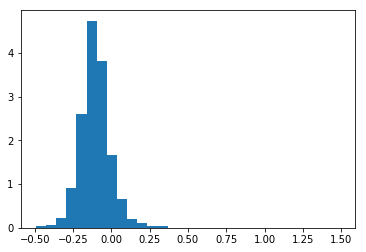

In [24]:
plt.hist(ld50,bins=30,density=True)

In [25]:
print(np.percentile(ld50,(2.5,25,50,75,97.5)))

[-0.28492907 -0.1626249  -0.10918016 -0.05240481  0.1043744 ]
